In [46]:
!pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


In [47]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import numpy as np
import seaborn as sns

In [21]:
df_mad = pd.read_csv('../../data/raw/data_aemet/estacion_3195_data.csv')
df_bar = pd.read_csv('../../data/raw/data_aemet/estacion_0201X_data.csv')
df_hoyo = pd.read_csv('../../data/raw/Open_Meteo/daily/Hoyo de Manzanares/estacion_ESMAD_data.csv')

In [22]:
df_bar["tmed"].describe()

count     1258
unique     213
top       13,4
freq        22
Name: tmed, dtype: object

In [23]:
df_mad["tmed"] = df_mad["tmed"].str.replace(',', '.').astype(float)
df_mad["tmin"] = df_mad["tmin"].str.replace(',', '.').astype(float)
df_mad["tmax"] = df_mad["tmax"].str.replace(',', '.').astype(float)

df_bar["tmed"] = df_bar["tmed"].str.replace(',', '.').astype(float)
df_bar["tmin"] = df_bar["tmin"].str.replace(',', '.').astype(float)
df_bar["tmax"] = df_bar["tmax"].str.replace(',', '.').astype(float)

In [24]:
df_bar["fecha"] = pd.to_datetime(df_bar["fecha"])
df_mad["fecha"] = pd.to_datetime(df_mad["fecha"])

In [29]:
df_hoyo["date"] = pd.to_datetime(df_hoyo["date"])


## Visualización de los datos de Temperatura media


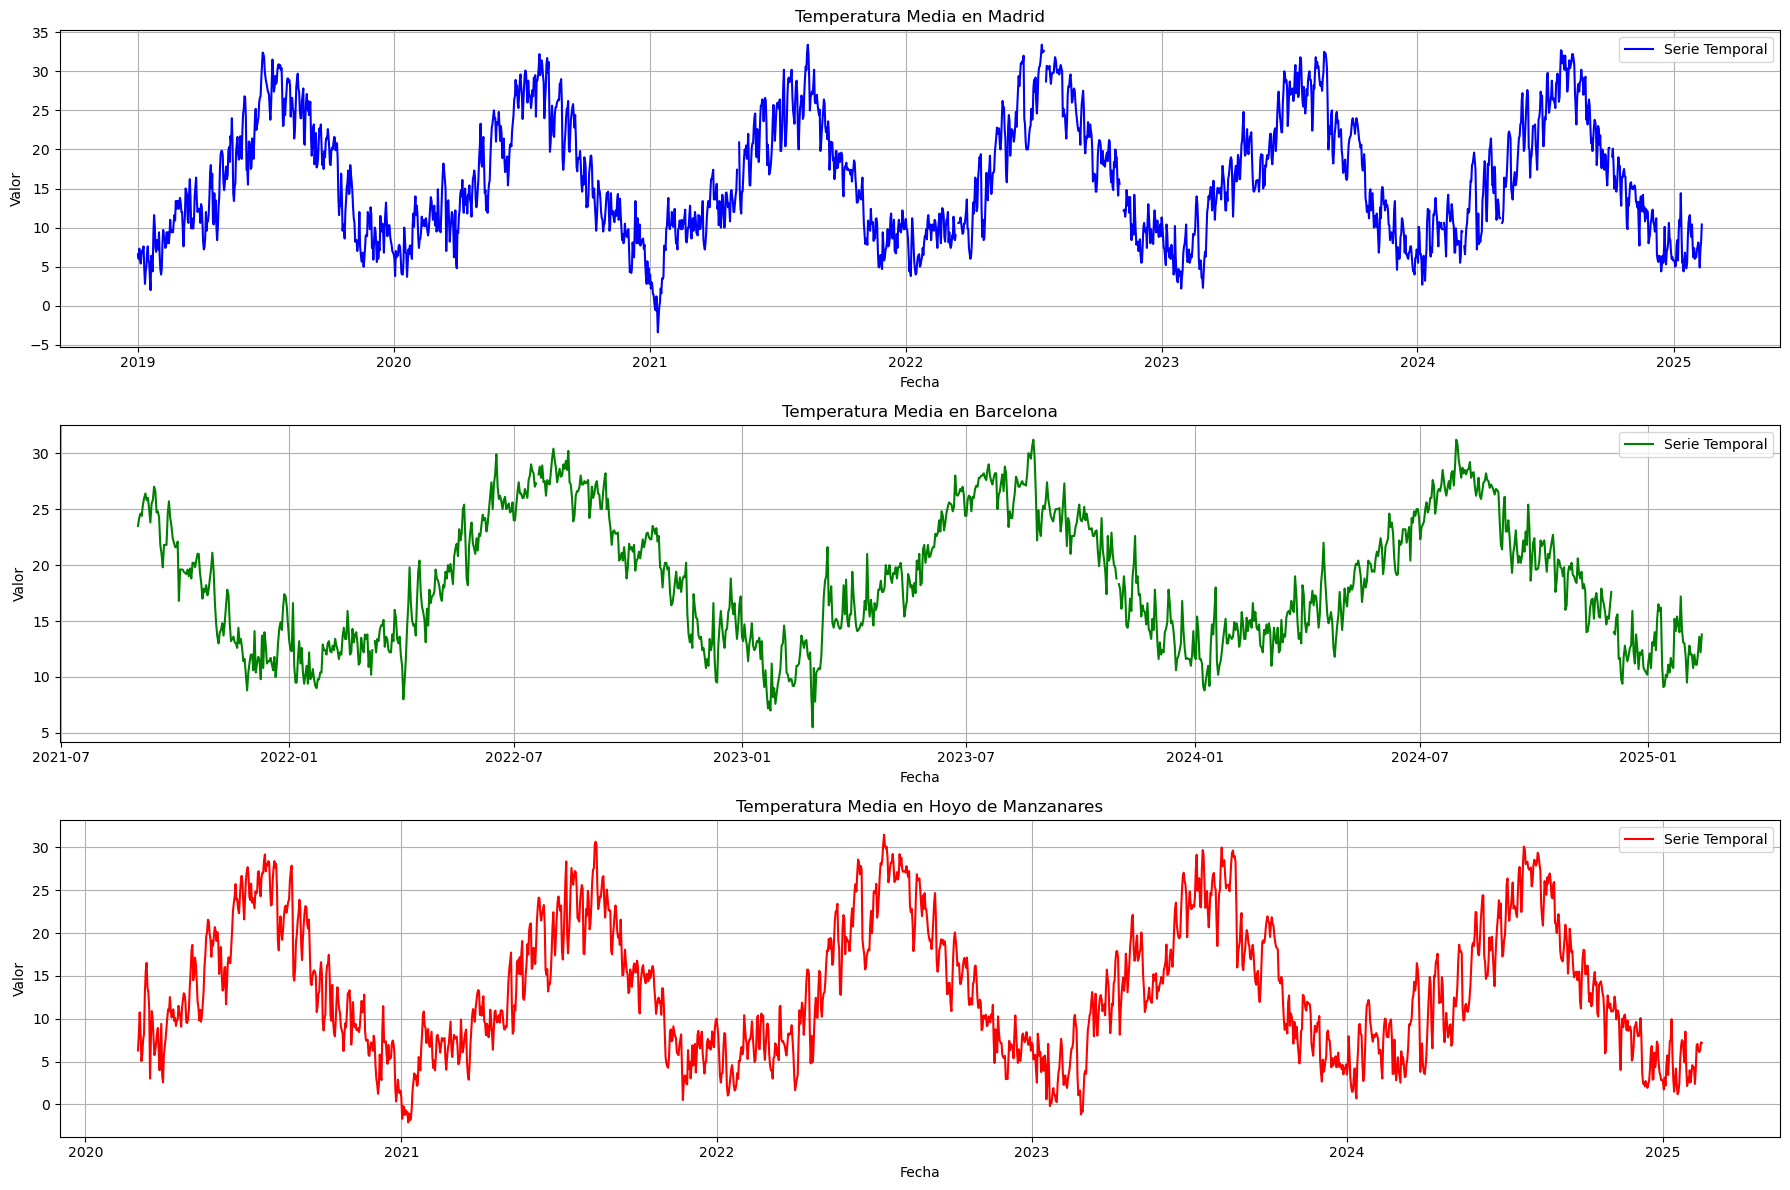

In [30]:
plt.figure(figsize=(18, 12))

plt.subplot(3, 1, 1)
plt.plot(df_mad["fecha"], df_mad["tmed"], label="Serie Temporal", color="b")
plt.xlabel("Fecha")
plt.ylabel("Valor")
plt.title("Temperatura Media en Madrid")
plt.legend()
plt.grid()

plt.subplot(3, 1, 2)
plt.plot(df_bar["fecha"], df_bar["tmed"], label="Serie Temporal", color="g")
plt.xlabel("Fecha")
plt.ylabel("Valor")
plt.title("Temperatura Media en Barcelona")
plt.legend()
plt.grid()

plt.subplot(3, 1, 3)
plt.plot(df_hoyo["date"], df_hoyo["temperature_2m_mean"], label="Serie Temporal", color="r")
plt.xlabel("Fecha")
plt.ylabel("Valor")
plt.title("Temperatura Media en Hoyo de Manzanares")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

In [40]:
print(f"Nulos en temperatura media Hoyo de Manzanares: {df_hoyo['temperature_2m_mean'].isna().sum()}")
print(f"Nulos en temperatura media Madrid: {df_mad['tmed'].isna().sum()}")
print(f"Nulos en temperatura media Barcelona: {df_bar['tmed'].isna().sum()}")

Nulos en temperatura media Hoyo de Manzanares: 0
Nulos en temperatura media Madrid: 0
Nulos en temperatura media Barcelona: 0


#### Para rellenar los nulos ya que son pocos vamos a usar el metodo ffill, este metodo rellena los datos faltantes con el valor del último dato


In [39]:
df_mad['tmed'] = df_mad['tmed'].ffill()
df_bar['tmed'] = df_bar['tmed'].ffill()

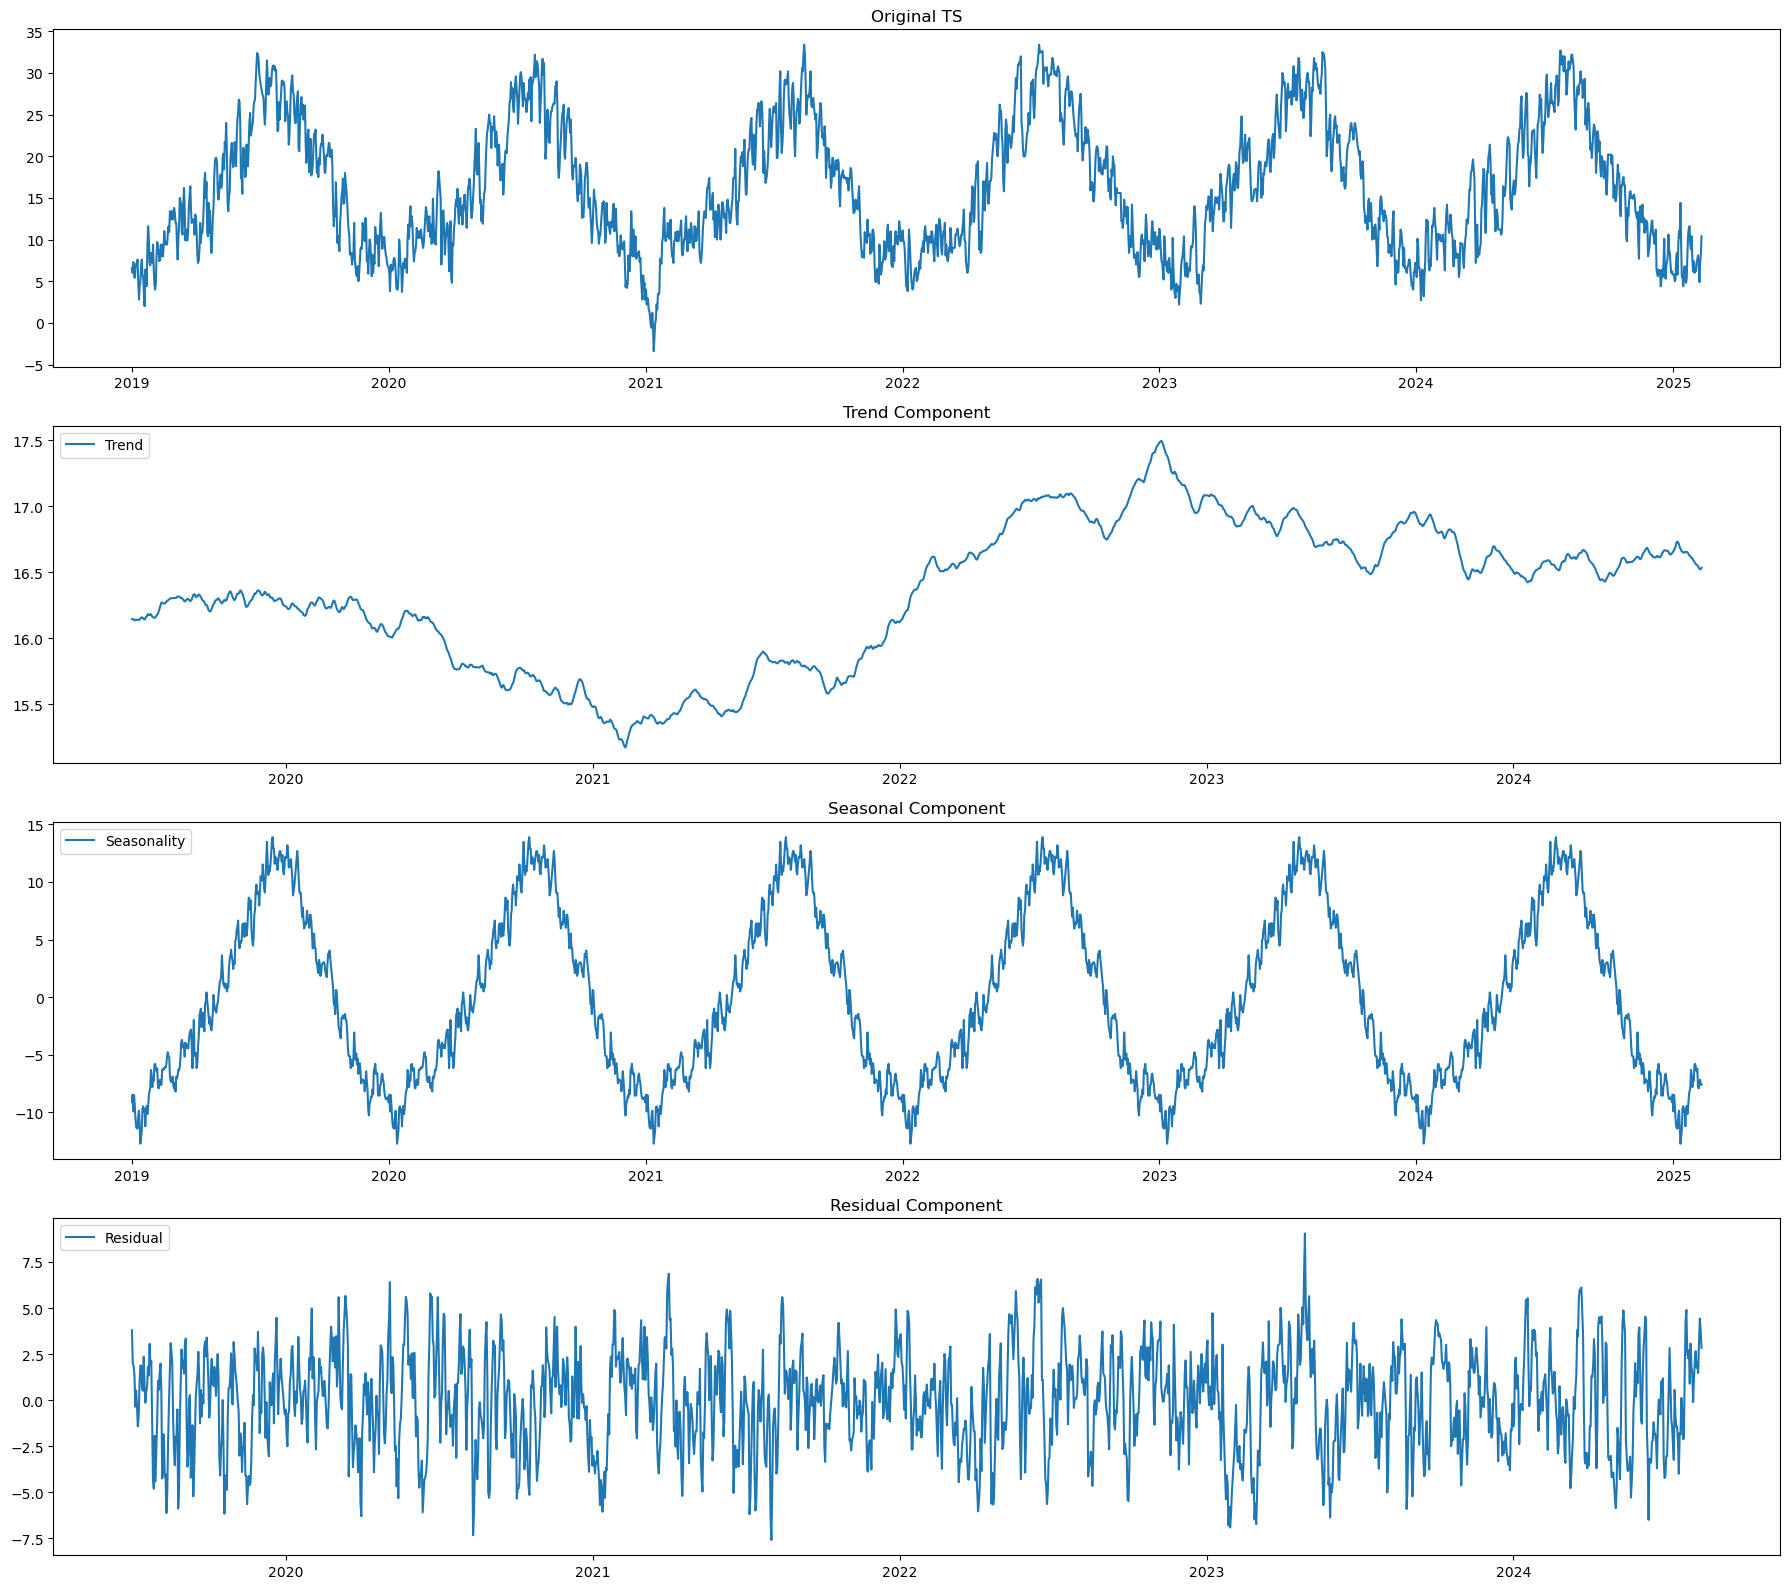

In [61]:
decomposition_air = seasonal_decompose(df_mad['tmed'], model='additive', period=365)

plt.figure(figsize=(18, 16))

plt.subplot(4, 1, 1)
plt.plot(df_mad["fecha"], df_mad["tmed"])
plt.title('Original TS')

plt.subplot(4, 1, 2)
plt.plot(df_mad["fecha"], decomposition_air.trend, label='Trend')
plt.legend(loc='upper left')
plt.title('Trend Component')

plt.subplot(4, 1, 3)
plt.plot(df_mad["fecha"], decomposition_air.seasonal, label='Seasonality')
plt.legend(loc='upper left')
plt.title('Seasonal Component')

plt.subplot(4, 1, 4)
plt.plot(df_mad["fecha"], decomposition_air.resid, label='Residual')
plt.legend(loc='upper left')
plt.title('Residual Component')

plt.tight_layout()
plt.show()

### Detección de outliers

In [42]:
window = 30  # 30 days window
threshold = 3  # Threshold of 2 standard deviations

ma = df_mad["tmed"].rolling(window=window, center=True).mean()
std = df_mad["tmed"].rolling(window=window, center=True).std()

#Treshold min and max
threshold_min = ma - std*threshold 
threshold_max = ma + std*threshold 

#Outliers detection
df_mad["outlier_ma"] = (np.abs(df_mad["tmed"] - ma) > threshold * std)

In [43]:
df_mad["outlier_ma"].value_counts()

outlier_ma
False    2233
Name: count, dtype: int64

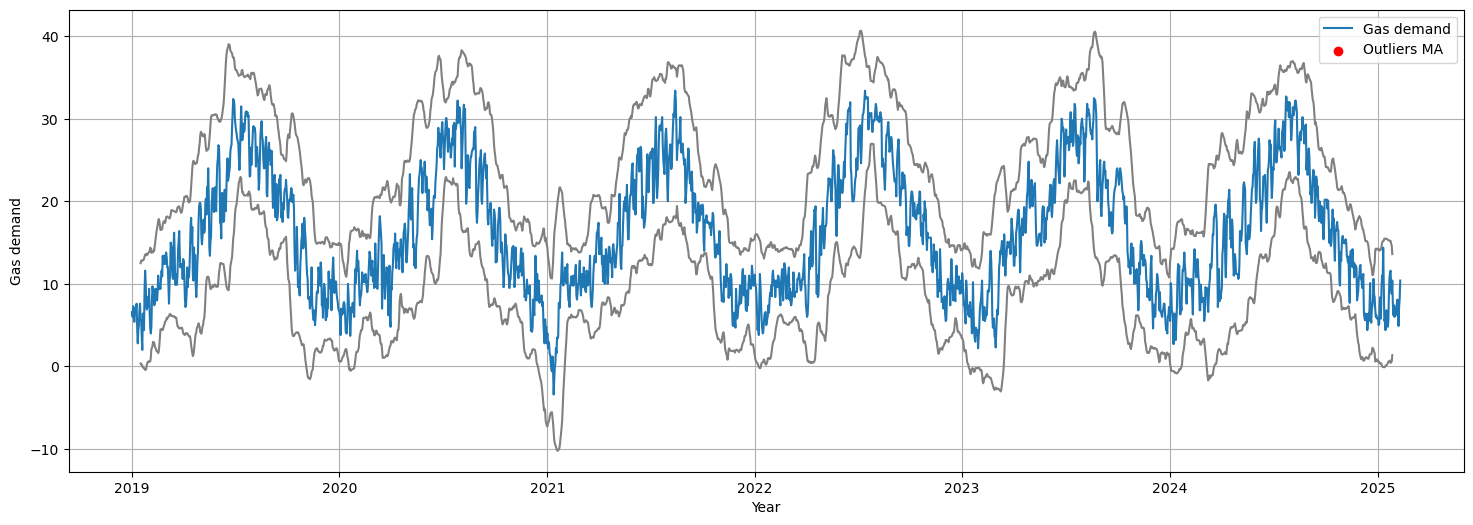

In [44]:
plt.figure(figsize=(18, 6))

plt.plot(df_mad['fecha'], df_mad['tmed'], label='Gas demand')
plt.plot(df_mad['fecha'], threshold_min, color='gray')
plt.plot(df_mad['fecha'], threshold_max, color='gray')
plt.scatter(df_mad["fecha"][df_mad["outlier_ma"]], df_mad["tmed"][df_mad["outlier_ma"]], color='red', label="Outliers MA")
plt.xlabel('Year')
plt.ylabel('Gas demand')
plt.legend()
plt.grid(True)
plt.show()

## Sacamos la matriz de correlación de los datos actuales de Temperatura Media con sus ultimos 3 dias y los datos del año anterior

In [45]:
df_mad['tmed_lag_1'] = df_mad['tmed'].shift(1)
df_mad['tmed_lag_2'] = df_mad['tmed'].shift(2)
df_mad['tmed_lag_3'] = df_mad['tmed'].shift(3)
df_mad['tmed_lag_365'] = df_mad['tmed'].shift(365)
df_mad['tmed_lag_366'] = df_mad['tmed'].shift(366)
df_mad['tmed_lag_367'] = df_mad['tmed'].shift(367)

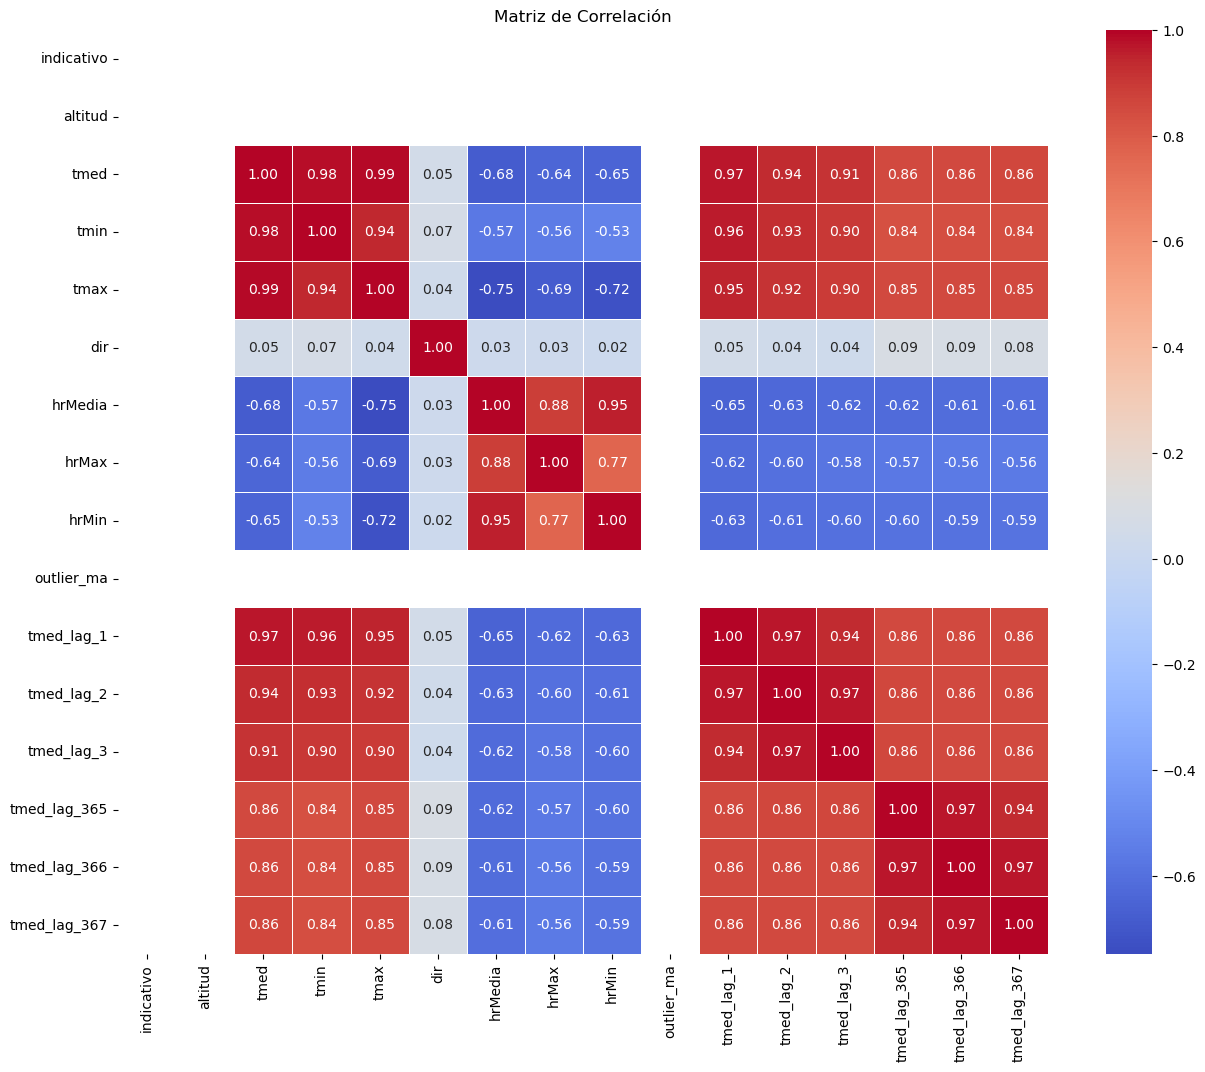

In [48]:
corr_matrix = df_mad.corr(numeric_only=True)

# Crear el mapa de calor
plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matriz de Correlación')

plt.show()

### Como se puede apreciar, tanto con los datos de los 3 días anteriores como los del año pasado la variable tiene una correlación super alta, incluso demasiado alta como para que sea util


## Medimos la estacionalidad usando el test de Dickey-Fuller

In [49]:
def check_stationarity(series, name):
    result = adfuller(series)
    print(f'ADF Statistic for {name}:', result[0])
    print('p-value:', result[1])
    if result[1] <= 0.05:
        print("The series is likely stationary.")
    else:
        print("The series is likely non-stationary.")

In [52]:
check_stationarity(df_mad['tmed'], 'tmed')

ADF Statistic for tmed: -3.0289243788909714
p-value: 0.032280102772937525
The series is likely stationary.


In [53]:
check_stationarity(df_bar['tmed'], 'tmed')

ADF Statistic for tmed: -2.0959258404290573
p-value: 0.2461559943028755
The series is likely non-stationary.


In [54]:
check_stationarity(df_hoyo['temperature_2m_mean'], 'temperature_2m_mean')

ADF Statistic for temperature_2m_mean: -2.7860225088758583
p-value: 0.0602982581507662
The series is likely non-stationary.


## Visualización de los datos de Humedad Relativa


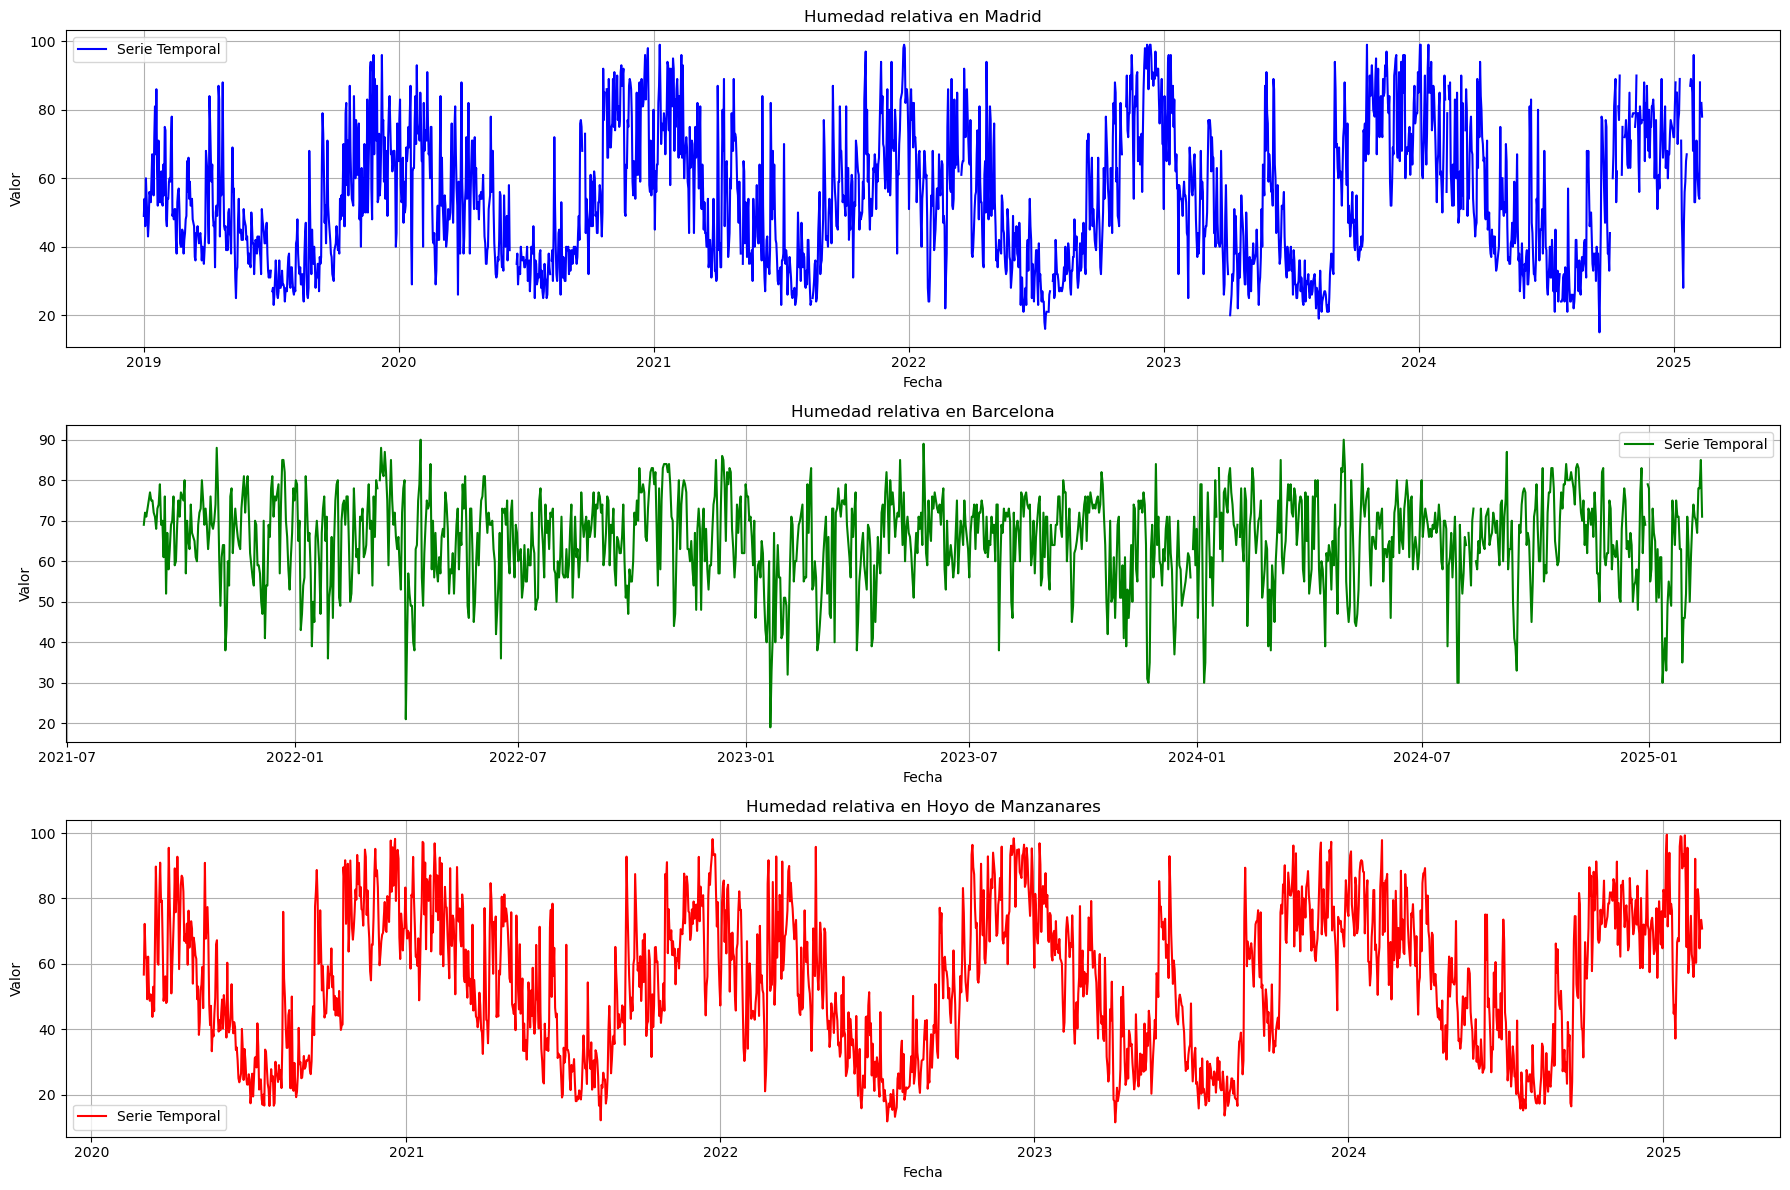

In [59]:
plt.figure(figsize=(18, 12))

plt.subplot(3, 1, 1)
plt.plot(df_mad["fecha"], df_mad["hrMedia"], label="Serie Temporal", color="b")
plt.xlabel("Fecha")
plt.ylabel("Valor")
plt.title("Humedad relativa en Madrid")
plt.legend()
plt.grid()

plt.subplot(3, 1, 2)
plt.plot(df_bar["fecha"], df_bar["hrMedia"], label="Serie Temporal", color="g")
plt.xlabel("Fecha")
plt.ylabel("Valor")
plt.title("Humedad relativa en Barcelona")
plt.legend()
plt.grid()

plt.subplot(3, 1, 3)
plt.plot(df_hoyo["date"], df_hoyo["relative_humidity_2m"], label="Serie Temporal", color="r")
plt.xlabel("Fecha")
plt.ylabel("Valor")
plt.title("Humedad relativa en Hoyo de Manzanares")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

In [63]:
print(f"Nulos en humedad relativa Hoyo de Manzanares: {df_hoyo['relative_humidity_2m'].isna().sum()}")
print(f"Nulos en humedad relativa Madrid: {df_mad['hrMedia'].isna().sum()}")
print(f"Nulos en humedad relativa Barcelona: {df_bar['hrMedia'].isna().sum()}")

Nulos en humedad relativa Hoyo de Manzanares: 0
Nulos en humedad relativa Madrid: 54
Nulos en humedad relativa Barcelona: 7


### Para rellenar los nulos ya que son pocos vamos a usar el metodo ffill, este metodo rellena los datos faltantes con el valor del último dato

In [65]:
df_mad['hrMedia'] = df_mad['hrMedia'].ffill()
df_bar['hrMedia'] = df_bar['hrMedia'].ffill()

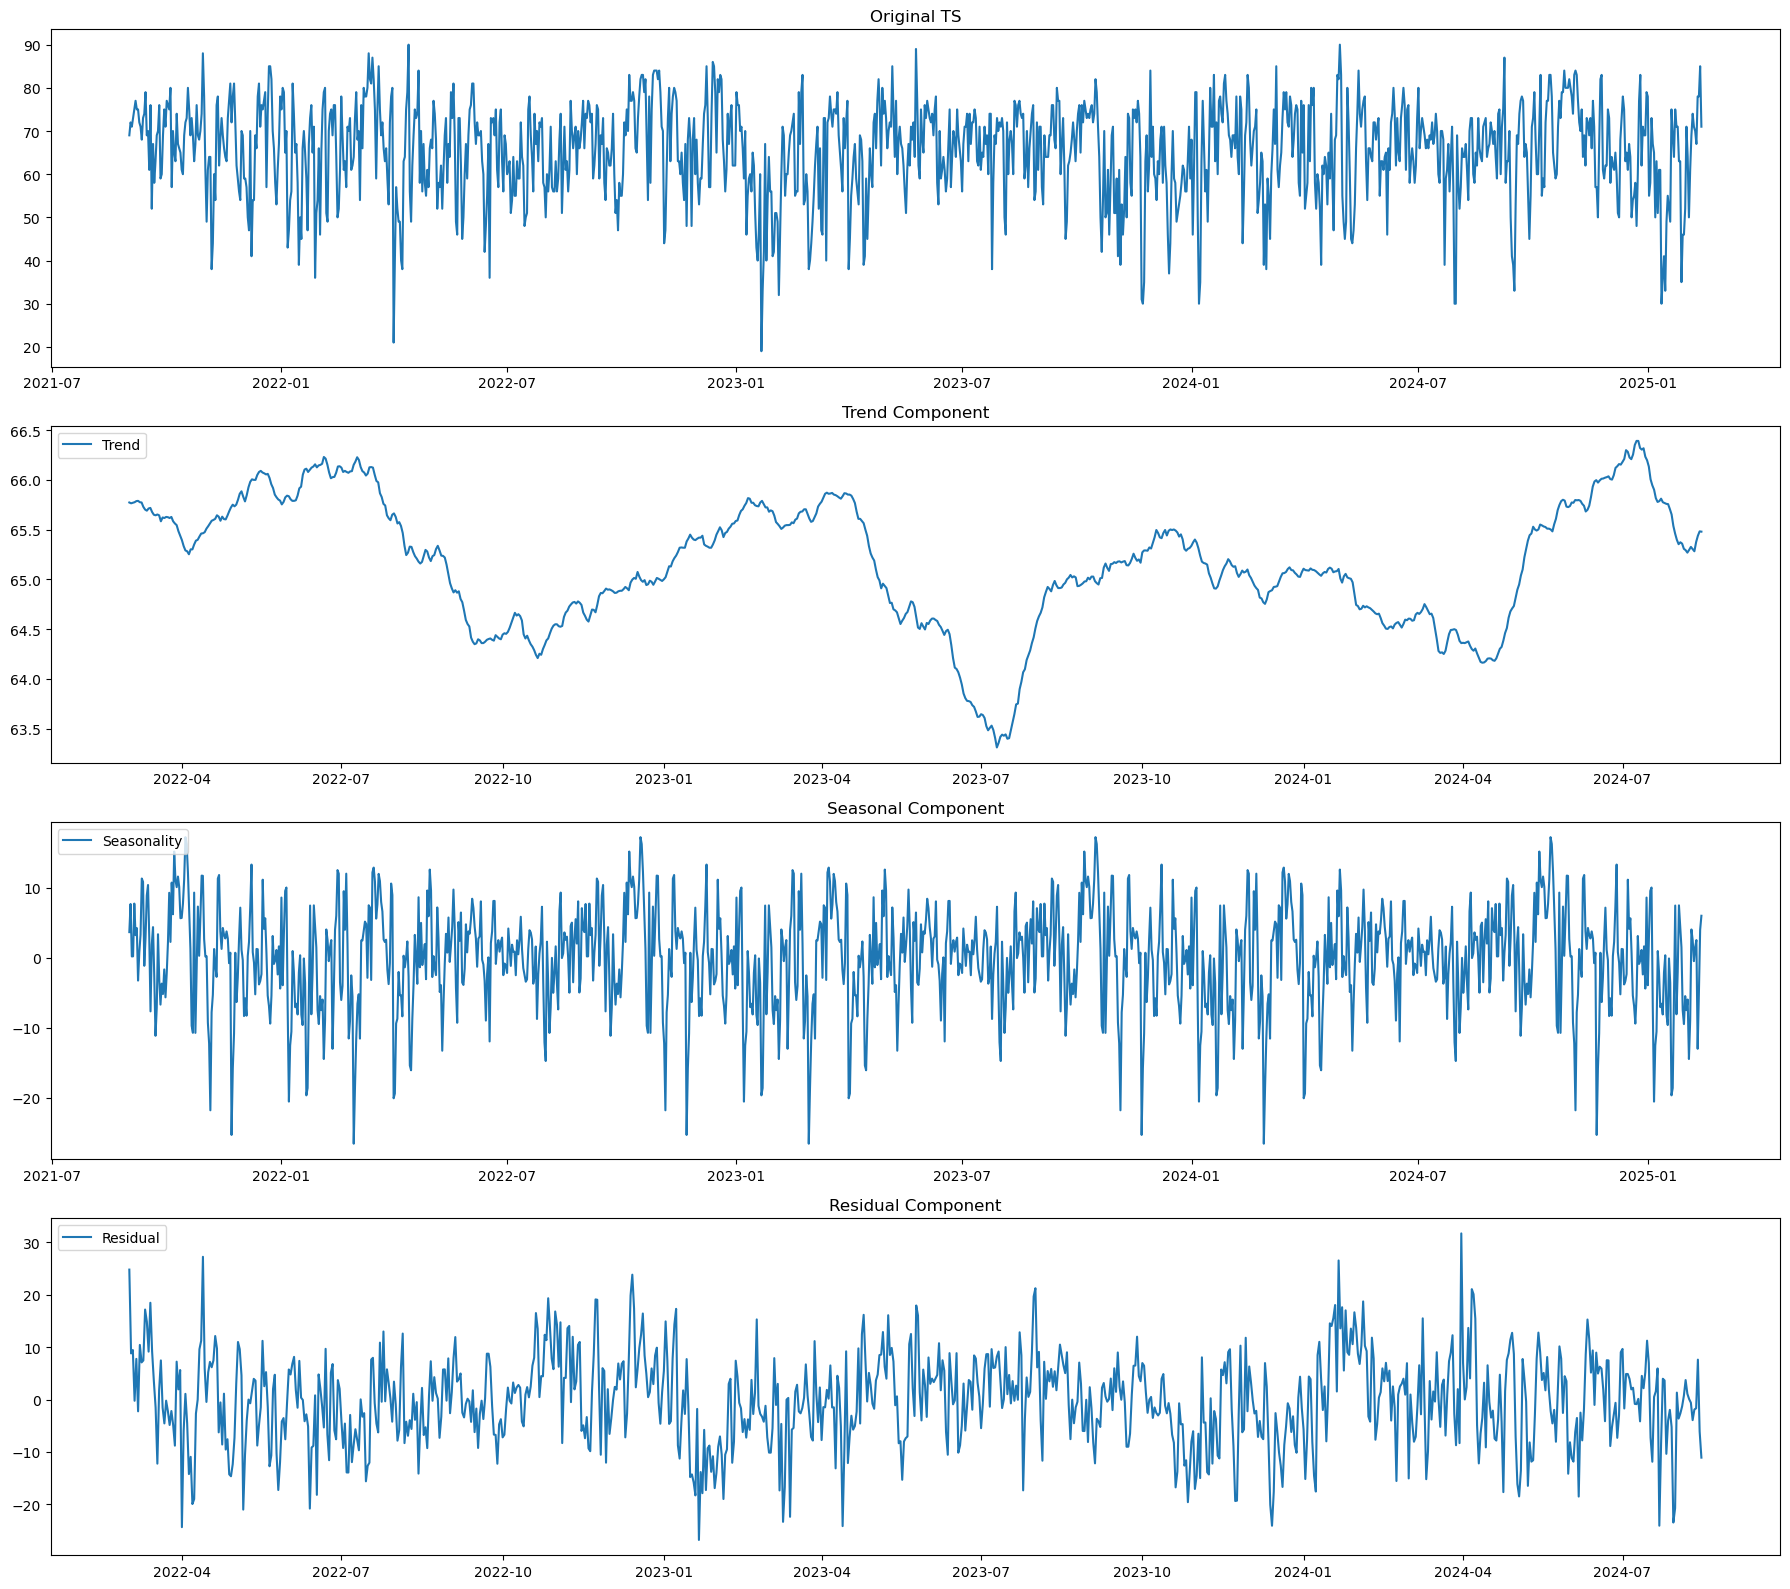

In [66]:
decomposition_air = seasonal_decompose(df_bar['hrMedia'], model='additive', period=365)

plt.figure(figsize=(18, 16))

plt.subplot(4, 1, 1)
plt.plot(df_bar["fecha"], df_bar["hrMedia"])
plt.title('Original TS')

plt.subplot(4, 1, 2)
plt.plot(df_bar["fecha"], decomposition_air.trend, label='Trend')
plt.legend(loc='upper left')
plt.title('Trend Component')

plt.subplot(4, 1, 3)
plt.plot(df_bar["fecha"], decomposition_air.seasonal, label='Seasonality')
plt.legend(loc='upper left')
plt.title('Seasonal Component')

plt.subplot(4, 1, 4)
plt.plot(df_bar["fecha"], decomposition_air.resid, label='Residual')
plt.legend(loc='upper left')
plt.title('Residual Component')

plt.tight_layout()
plt.show()

In [69]:
window = 30  # 30 days window
threshold = 3  # Threshold of 2 standard deviations

ma = df_bar["hrMedia"].rolling(window=window, center=True).mean()
std = df_bar["hrMedia"].rolling(window=window, center=True).std()

#Treshold min and max
threshold_min = ma - std*threshold 
threshold_max = ma + std*threshold 

#Outliers detection
df_bar["outlier_ma"] = (np.abs(df_bar["hrMedia"] - ma) > threshold * std)

In [70]:
df_bar["outlier_ma"].value_counts()

outlier_ma
False    1261
True        1
Name: count, dtype: int64

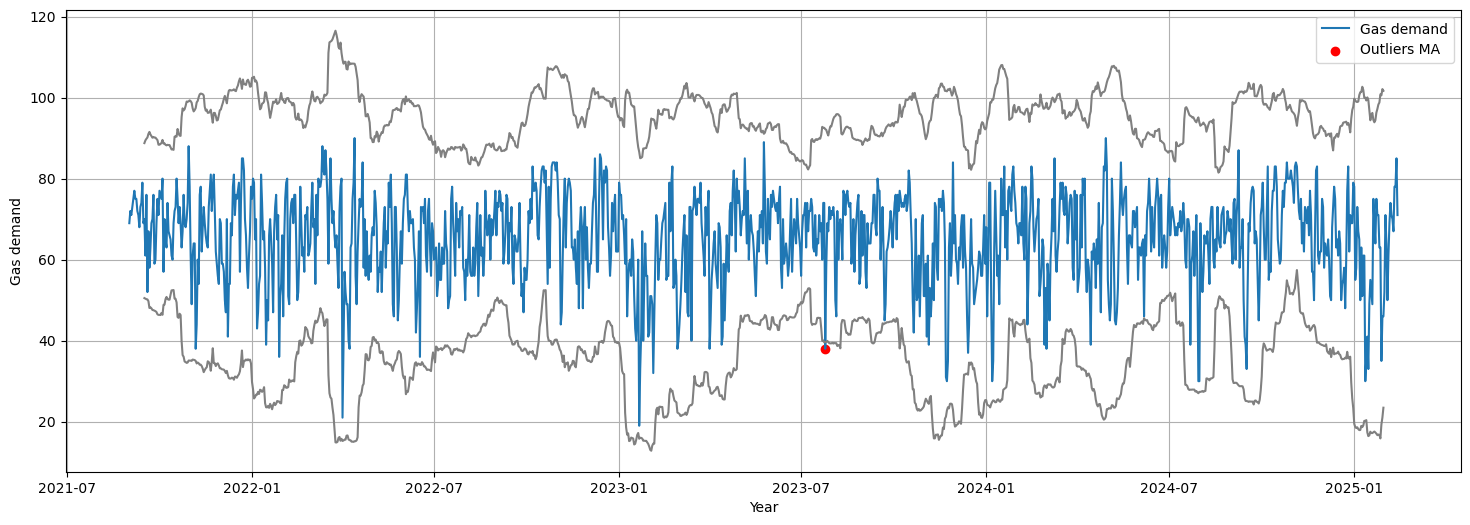

In [72]:
plt.figure(figsize=(18, 6))

plt.plot(df_bar['fecha'], df_bar['hrMedia'], label='Gas demand')
plt.plot(df_bar['fecha'], threshold_min, color='gray')
plt.plot(df_bar['fecha'], threshold_max, color='gray')
plt.scatter(df_bar["fecha"][df_bar["outlier_ma"]], df_bar["hrMedia"][df_bar["outlier_ma"]], color='red', label="Outliers MA")
plt.xlabel('Year')
plt.ylabel('Gas demand')
plt.legend()
plt.grid(True)
plt.show()

## Sacamos la matriz de correlación de los datos actuales de Humedad con sus ultimos 3 dias y los datos del año anterior


In [73]:
df_bar['hrMedia_lag_1'] = df_bar['hrMedia'].shift(1)
df_bar['hrMedia_lag_2'] = df_bar['hrMedia'].shift(2)
df_bar['hrMedia_lag_3'] = df_bar['hrMedia'].shift(3)
df_bar['hrMedia_lag_365'] = df_bar['hrMedia'].shift(365)
df_bar['hrMedia_lag_366'] = df_bar['hrMedia'].shift(366)
df_bar['hrMedia_lag_367'] = df_bar['hrMedia'].shift(367)

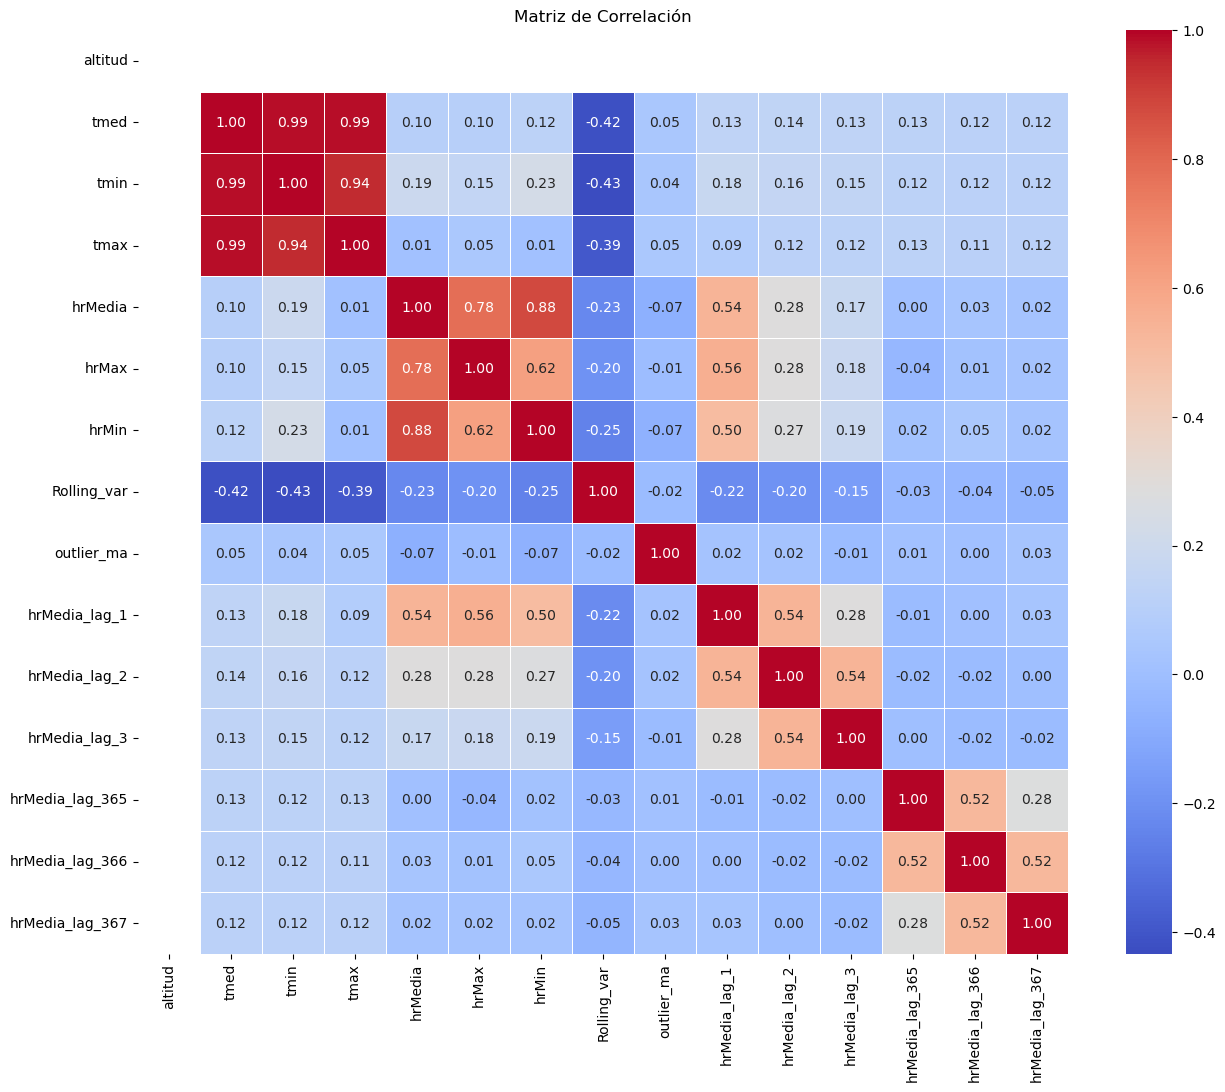

In [74]:
corr_matrix = df_bar.corr(numeric_only=True)

# Crear el mapa de calor
plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matriz de Correlación')

plt.show()

### Como se puede apreciar, tanto con los datos de los 3 días anteriores como los del año pasado la variable tiene una correlación casi nula.

## Medimos la estacionalidad de la time series de Humedad relativa

In [75]:
check_stationarity(df_mad['hrMedia'], 'hrMedia')

ADF Statistic for hrMedia: -4.587736617517757
p-value: 0.00013606203385745484
The series is likely stationary.


In [76]:
check_stationarity(df_bar['hrMedia'], 'hrMedia')

ADF Statistic for hrMedia: -12.687396922824853
p-value: 1.1516790061477908e-23
The series is likely stationary.


In [77]:
check_stationarity(df_hoyo['relative_humidity_2m'], 'relative_humidity_2m')

ADF Statistic for relative_humidity_2m: -3.8407549393543117
p-value: 0.002516806780882423
The series is likely stationary.
